# Stabilizer Codes and Implementing the Steane Code

If there is a file import error make sure you are in the correct path

In [ ]:
import sys
sys.path.append('..')   # the `general_qec` package sits above us

In [ ]:
import numpy as np
import random
from general_qec.qec_helpers import *
from general_qec.gates import *
from circuit_specific.steane_helpers import *

It is important to note that when we measure the logical states of our qubit systems we will only actually "see" one of the states that make up our superposition terms of our qubit system state. This will happen in many notebooks but it is important to keep in mind that it is only for example's sake.

For example, if our state is $\vert\psi\rangle = \alpha\vert000\rangle + \beta\vert111\rangle$ we will either measure $\vert000\rangle$ or $\vert111\rangle$, never both! 

Another useful example that well come across is when we use ancilla qubits and measure them, collapsing our state. Let's say our state is $\vert\psi\rangle = \alpha_1\vert00001\rangle + \alpha_1\vert00010\rangle + \beta_2\vert11101\rangle + \beta_2\vert11110\rangle$. And let's say we measure our two ancilla qubits at the end (right side of our bit representation). The the states we would get are $\vert\psi\rangle = \gamma_1\vert00001\rangle + \lambda_1\vert11101\rangle$ or $\vert\psi\rangle = \gamma_2\vert00010\rangle + \lambda_2\vert11110\rangle$, but again never both!

In our notebooks, we just display this information to show the current quantum state although, physically, this would never be possible.

## Contents
1. [Introduction](#introduction)
    1. [3 qubit code example](#three)
2. [Quantum Error Correction with Stabilizer Codes](#qec)
    1. [5 qubit implementation](#five)
3. [State Preparation Using Stabilizers](#prep)
4. [Implementing the 7 qubit Steane code](#seven)
    1. [Error Correction with the Steane Code using Stabilizer Formalism](#correction)
    2. [Using two ancilla blocks](#larger)

# 1. Introduction <a id='introduction'></a>

In this notebook we will introduce the idea of Stabilizer codes since they are very useful in quantum computation and error correction.

## What is a Stabilizer?

Stabilizer formalism was first developed by Daniel Gottesman. Stabilizers make use of the Pauli Operators ($\sigma_x,\space\sigma_y,\space\sigma_z,\space\sigma_I$) by acting on a logical qubit with a special combination of the Pauli group. They have two very useful properites:

1. They commute with each other, which means that they can be measured simultaneously.
2. They have eigenvalues of +1 or -1, which means that they do not collapse the state of the qubit (physical or logical).

Additionally they either commute or anti-commute with error states. These properites make them extremely useful when correcting for errors.

Some useful references:

* https://en.wikipedia.org/wiki/Stabilizer_code
* Devitt et al. - 2013 - Quantum Error Correction for Beginners (pgs 12 - 16)
* Girvin - 2023 - Introduction to Quantum Error Correction and Fault (pgs 37 - 40)
* https://arthurpesah.me/blog/
* https://thesis.library.caltech.edu/2900/2/THESIS.pdf

## A. 3 qubit code example <a id='three'></a>

Lets define our two stabilizer operators as $ S_1 = Z_1Z_2$ and $S_2 = Z_2Z_3$. We can see that they commute $S_1S_2 = S_2S_1$ and they commute with the logical qubit operators for the 3 qubit code ($X_L = X_1X_2X_3$, $Y_L = -Y_1Y_2Y_3$, and $Z_L = Z_1Z_2Z_3$).
Now since the 3 qubit code only corrects for a maximum of one bit flip error we can apply each of these stabilizer operators to the logical state of the qubit and read back the eigenvalues. Let's run through some examples of possible errors that can occur.

No error: $ \vert\psi\rangle_L = \alpha\vert000\rangle + \beta\vert111\rangle: \quad S_1(\alpha\vert000\rangle + \beta\vert111\rangle) = +(\alpha\vert000\rangle + \beta\vert111\rangle), \quad S_2(\alpha\vert000\rangle + \beta\vert111\rangle) = +(\alpha\vert000\rangle + \beta\vert111\rangle) $

Error on qubit 1 ($X_1$): $\vert\psi\rangle_L = \alpha\vert100\rangle + \beta\vert011\rangle: \quad S_1(\alpha\vert100\rangle + \beta\vert011\rangle) = -(\alpha\vert100\rangle + \beta\vert011\rangle), \quad S_2(\alpha\vert100\rangle + \beta\vert011\rangle) = +(\alpha\vert100\rangle + \beta\vert011\rangle)$

Error on qubit 2 ($X_2$): $\vert\psi\rangle_L = \alpha\vert010\rangle + \beta\vert101\rangle: \quad S_1(\alpha\vert010\rangle + \beta\vert101\rangle) = -(\alpha\vert010\rangle + \beta\vert101\rangle), \quad S_2(\alpha\vert010\rangle + \beta\vert101\rangle) = -(\alpha\vert010\rangle + \beta\vert101\rangle)$

Error on qubit 3 ($X_3$): $\vert\psi\rangle_L = \alpha\vert001\rangle + \beta\vert110\rangle: \quad S_1(\alpha\vert001\rangle + \beta\vert110\rangle) = +(\alpha\vert001\rangle + \beta\vert110\rangle), \quad S_2(\alpha\vert001\rangle + \beta\vert110\rangle) = -(\alpha\vert001\rangle + \beta\vert110\rangle)$

As we can see from above, each error will cause a distinct eigenvalue combination for the stabilizer operators, and we have a total of 4 errors and a total of 4 combinations. With this we can correct the designated error using the error syndrome from the stabilizer eigenvalues. Thus in order to use stabilizer codes we must use logical states that are +1 eigenstates of the stabilizer operators. We can construct these for different systems.

## 2. Quantum Error Correction with Stabilizer Codes <a id='qec'></a>

In this section we will focus on the 7-qubit Steane code.

We can define quantum codes as [[n, k, d]] where there are n physical qubits, k logical qubits encoded, and d distance between basis states. Thus in the 7 qubit code we can define it as [[7, 1, 3]]. We know that quantum codes can correct for $ t = \left\lfloor \frac{(d-1)}{2} \right\rfloor$ errors. Thus the 7 qubit code can correct for $ t = \left\lfloor \frac{(3-1)}{2} \right\rfloor = 1$ error.

We define our two basis states as 

$$ \vert0\rangle_L = \frac{1}{\sqrt{8}}(\vert0000000\rangle + \vert1010101\rangle + \vert0110011\rangle + \vert1100110\rangle + \vert0001111\rangle + \vert1011010\rangle + \vert0111100\rangle + \vert1101001\rangle) $$

$$ \vert1\rangle_L = \frac{1}{\sqrt{8}}(\vert1111111\rangle + \vert0101010\rangle + \vert1001100\rangle + \vert0011001\rangle + \vert1110000\rangle + \vert0100101\rangle + \vert1000011\rangle + \vert0010110\rangle) $$

For a n qubit state the dimension of the hilbert space is $2^n$, but for a single logical qubit we must restrict to a 2 dimensional hilbert space. This can be accomplished using stabilizer code. The stabilizer code used for the 7-qubit logical states above consist of the six operators below.

$$ K^1 = IIIXXXX, \quad K^2 = XIXIXIX, \quad K^3 = IXXIIXX, $$
$$K^4 = IIIZZZZ, \quad K^5 = ZIZIZIZ, \quad K^6 = IZZIIZZ $$

Becuase there are six stabilizer operators for the two logical states above and the operators span over a 6 dimensional subspace then we can see that the new dimensionality of the 7-qubit system is $2^{7-6} = 2$. Since the two 7-qubit logical states of the system are orthogonal basis states then we have a 2 dimensional system that we can use as a logical qubit. (In general a stabilizer with k linearly independent operators and Hilbert space of $2^n$ with with n qubits will now have a dimension of $2^{n-k}$)

The last operator used fixes the encoded state to one of the two codeword states. In this case we use $\bar Z = ZZZZZZZ$, since $\bar Z\vert0\rangle_L = \vert0\rangle_L$ and $\bar Z\vert1\rangle_L = -\vert1\rangle_L$

## A. 5 qubit implementation <a id='five'></a>

Below we demonstrate the code to derive the 5 qubit logical state from the stabilizer code structure. 
In this case we have 4 stabilizers: $ K^1 = XZZXI, \space K^2 = IXZZX, \space K^3 = XIXZZ, \space K^4 = ZXIXZ $

We will also use the logical operator $\bar{Z} = ZZZZZ $ that will fix our state to either the $\vert0\rangle_L$ or $\vert1\rangle_L$ state. In order to calculate $\vert0\rangle_L$ from an initial state, we will need to project into a +1 eigenstate of the stabilzer operators. We can do this by applying the following operation to our initial state: 

$$\vert0\rangle_L = \prod_{i=1}^{4}(I^{\otimes5} + K^i)\vert00000\rangle$$

In [ ]:
# Set the initial state of the 5 qubit system
initial_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))

# Set the 4 stabilizer operators
k_one = np.kron(sigma_x, np.kron(sigma_z, np.kron(sigma_z, np.kron(sigma_x, sigma_I))))
k_two = np.kron(sigma_I, np.kron(sigma_x, np.kron(sigma_z, np.kron(sigma_z, sigma_x))))
k_three = np.kron(sigma_x, np.kron(sigma_I, np.kron(sigma_x, np.kron(sigma_z, sigma_z))))
k_four = np.kron(sigma_z, np.kron(sigma_x, np.kron(sigma_I, np.kron(sigma_x, sigma_z))))

# Set the logical Z operator to fix the logical state to either a 0 or a 1
z_bar = np.kron(sigma_z, np.kron(sigma_z, np.kron(sigma_z, np.kron(sigma_z, sigma_z))))

# Create and apply the stebilizer operation on the 5 qubit system
operation = np.dot((np.identity(2**5) + k_one), np.dot(
    (np.identity(2**5) + k_two), np.dot((np.identity(2**5) + k_three), (np.identity(2**5) + k_four))))
final_state = 0.25* np.dot(operation, initial_state)

# Find the bit represenation of the vector state
bits, indexes, state = vector_state_to_bit_state(final_state, 5)
    
print('initialized logical |0> state: ')
print_state_info(state, 5)

In [ ]:
# Applying Z bar to show that the final state will not change since we initialize to |00000>
final_state = np.dot(z_bar, 0.25* np.dot(operation, initial_state))

# Find the bit represenation of the vector state
bits, indexes, state = vector_state_to_bit_state(final_state, 5)

print('initialized logical |0> state: ')
print_state_info(state, 5)

This leads us into the next part of using stabilizer code: 

## 3. State Preparation using Stabilizers <a id='prep'></a>

Since our two codeword states will be +1 eigenstates of the stabilizers we need to take our initial arbitrary state and project it into the eigenstates of each operator. We can show this by applying the unitary and Hermition operator U, where the measurement result of the ancilla will determine which eigenstate (corresponding to $\pm 1$ becuase any unitary operator has only eigenvalues of $\pm1$) $\vert\psi\rangle_I$ will be projected to. 

Fig. 7 from Devitt et al. - 2013 - Quantum Error Correction for Beginners:

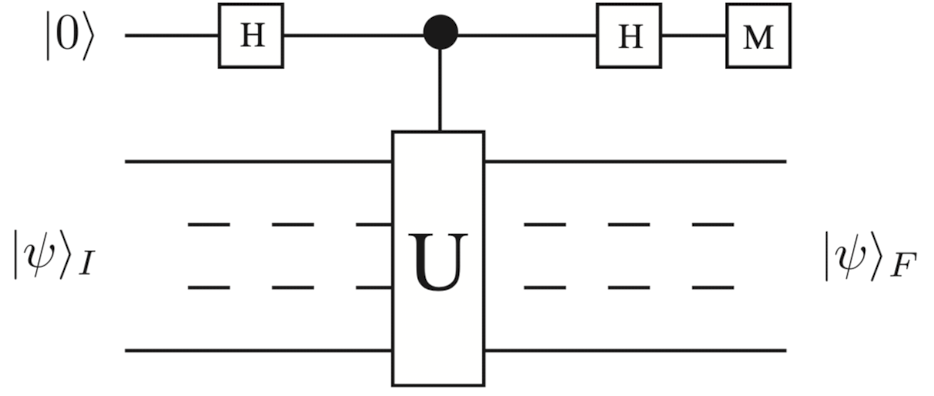

We can demonstrate the above circuit known as the parity measurement mathematically.

We have $\vert\psi\rangle_I\vert0\rangle$ initially, but after the first Hadamard gate will turn to $\vert\psi\rangle_I \frac{1}{\sqrt2} \biggl(\vert0\rangle + \vert1\rangle\biggr) = \frac{1}{\sqrt2} \biggl(\vert\psi\rangle_I\vert0\rangle + \vert\psi\rangle_I\vert1\rangle\biggr)$. 

Then when we apply the Controlled-Unitary gate we get $\frac{1}{\sqrt2} \biggl(\vert\psi\rangle_I\vert0\rangle + U\vert\psi\rangle_I\vert1\rangle\biggr)$. 

After this we apply the second Hadamard gate and get $\frac{1}{2}\biggl(\vert\psi\rangle_I\vert0\rangle + \vert\psi\rangle_I\vert1\rangle\biggr) + \frac{1}{2}\biggl(U\vert\psi\rangle_I\vert0\rangle - U\vert\psi\rangle_I\vert1\rangle\biggr)$

We can move some things around so that our final state looks like $\vert\psi\rangle_F  = \frac{1}{2}\biggl(\vert\psi\rangle_I + U\vert\psi\rangle_I\biggr)\vert0\rangle + \frac{1}{2}\biggl(\vert\psi\rangle_I - U\vert\psi\rangle_I\biggr)\vert1\rangle$

At the last step we measure the ancilla qubit in the computational basis ($\vert0\rangle$ and $\vert1\rangle$) and then project the input state depending on the syndrome value we measure:
If the ancilla is measured to be $\vert0\rangle$: $\vert\psi\rangle_F = \vert\psi\rangle_I + U\vert\psi\rangle_I$, and if the ancilla is measured to be $\vert1\rangle$: $\vert\psi\rangle_F = \vert\psi\rangle_I - U\vert\psi\rangle_I$

## 4. Implementing the 7 qubit Steane code <a id='seven'></a>

We can now look at the 7-qubit Steane code implementation of Stabilizer code. In the [[7, 1, 3]] code we will first initialize our 7 qubits in the state $\vert0\rangle^{\otimes7}$ and we apply the circuit above 3 times with $U = K^1, K^2, K^3$. This will project the initial state to $\pm1$ eigenstates of each X stabilizer operators from above. This operation will change each syndrome ancilla qubit and we apply a single qubit Z gate depending on what the syndrome measurement is. The change to the specific qubit is made depending on $i = M_1 (2^4) + M_3 (2^1) + M_2 (2^0)$, which tells us which qubit we need to apply a Z gate to.
We don't need to apply the Z stabilizer operators from the [[7, 1, 3]] code because $\vert0\rangle^{\otimes7}$ is already a +1 eigenstate of $K^4, K^5, K^6$. 

Fig. 8 from Devitt et al. - 2013 - Quantum Error Correction for Beginners:

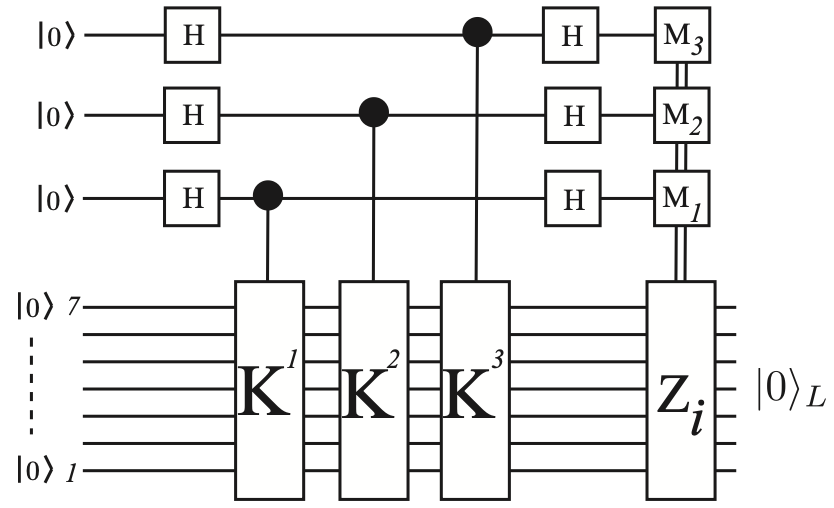

It is importaant to note however, that to initialize any superpostition state we would need to also apply the other 3 Stabilizer operators. This is due to the fact that a superposition of states is a superposition of a +1 and -1 eigenstate of $K^4, K^5, K^6$. You can look at the next circuit (image below) to see how the setup works.

For finding controlled unitary matrix operations

https://quantumcomputing.stackexchange.com/questions/17599/how-to-represent-a-cnot-gate-operating-on-three-qubit-states-as-a-matrix

https://quantumcomputing.stackexchange.com/questions/15098/how-does-a-generic-controlled-u-operation-work

https://quantumcomputing.stackexchange.com/questions/24403/what-is-the-matrix-representation-of-a-generic-two-qubit-controlled-unitary-oper

Explains what happens at each stage a stabilizer is applied:
https://quantumcomputing.stackexchange.com/questions/13033/how-to-create-the-logical-0-l-rangle-state-for-the-steanes-7-qubit-code

In [ ]:
zero = np.array([1, 0])
one = np.array([0, 1])

# Set the initial states of your physical qubits
initial_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))
# initial_state = np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))))
# initial_state = 1/np.sqrt(2) * np.kron(np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(
#     np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(
#         np.array([[1,1]]), np.array([[1,1]])))))))

# initialize a logical state 
# (sqrt(8) used for normalization of |0> or |1> states, superposition needs to be calcultated)

vector_state = initialize_steane_logical_state(initial_state)

# output our state after measuring the ancilla qubits and applying our z gate
print('initialized logical state')
print_state_info(vector_state, 10)

## A. Error Correction with the Steane Code using Stabilizer Formalism <a id='correction'></a>

Now that we have initialized our logical qubit state, we can correct one bit flip and/or one phase flip error. Its actually pretty similar to what we just did with the state preparation.

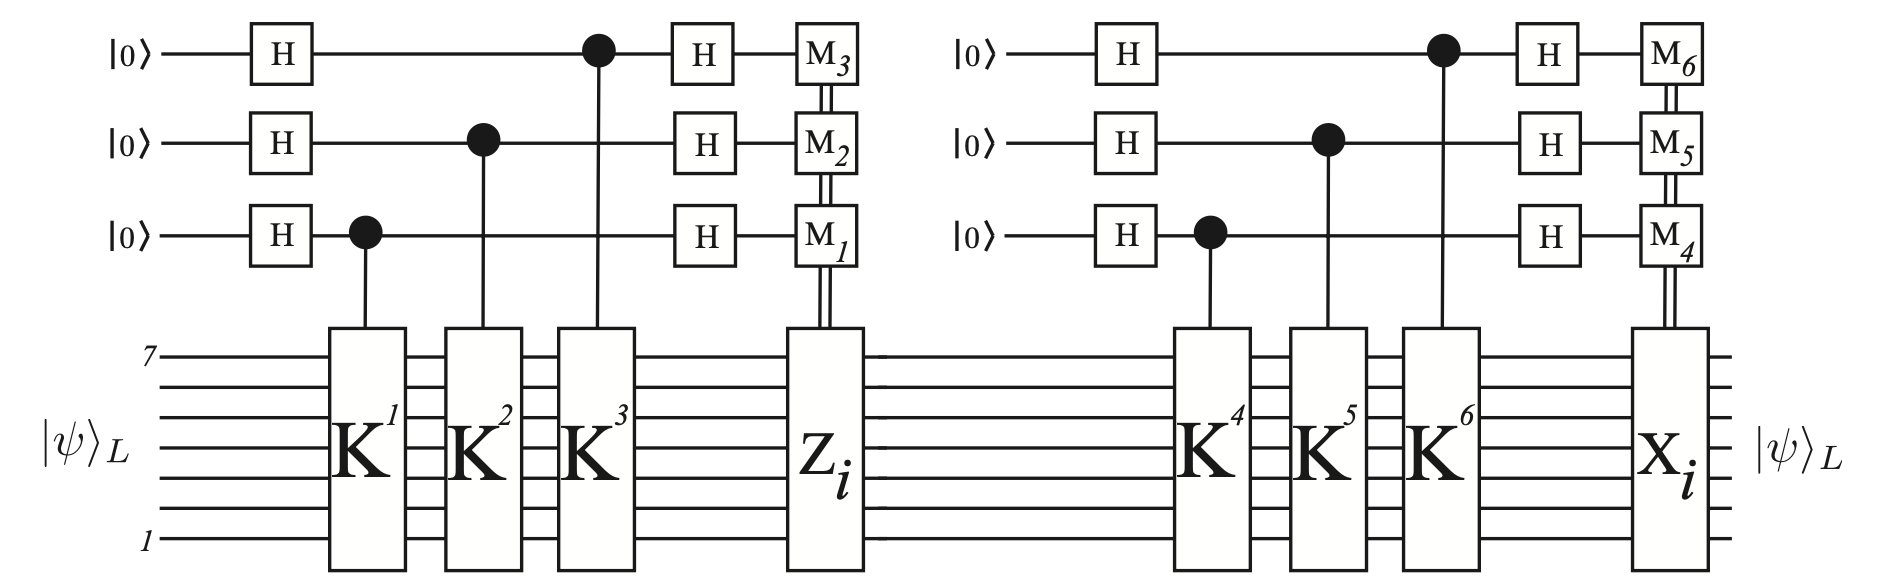

As we can see the left side of the circuit is exactly what we just did to initialize our logical state. That is because this side will correct for phase flip errors (Z) by applying $K^1, K^2, K^3$ operators, then applying the designated $Z_i$ gate on qubit $i = M_1 (2^4) + M_3 (2^1) + M_2 (2^0)$. The right side will help us correct for bit flip errors (X) by applying $K^4, K^5, K^6$ operators, then applying the designated $X_i$ gate on qubit $i = M_4 (2^4) + M_6 (2^1) + M_5 (2^0)$.

Below we create two functions to apply errors to our qubit logical system

In [ ]:
# First we need to reset the ancilla qubits from the initialization process:
final_vector_state = ancilla_reset(vector_state, 3)

# Display the current state (with ancillas)
print('Logical state: (with ancillas reset)')
print_state_info(final_vector_state, 10)

In [ ]:
# the phase error we will generate occurs on a random qubit and may not occur, so let's fix the randomness...
random.seed(11) 

# errored_vector_state = phase_flip_error(bit_flip_error(final_vector_state, 10)[0], 10)[0]
errored_vector_state, index = phase_flip_error(final_vector_state, 10)
print('error on index: ', index)

# Display the current state (remove ancillas)
print('Errored logical state: ')
print_state_info(errored_vector_state, 7)

First we will correct for the phase flip error using the same method as when we initialized the logical state

In [ ]:
phase_corrected_state = steane_phase_correction(errored_vector_state)

# Display the current state (remove ancillas)
print('Phase corrected logical state: ')
print_state_info(phase_corrected_state, 7)

Now trying with a bit flip error:

In [ ]:
# the phase error we will generate occurs on a random qubit and may not occur, so let's fix the randomness...
random.seed(11) 

errored_vector_state, index = bit_flip_error(final_vector_state, 10)
print('error index: ', index)

# Display the current state (remove ancillas)
print('Errored logical state: ')
print_state_info(errored_vector_state, 7)

In [ ]:
bit_corrected_state = steane_bit_correction(errored_vector_state)

# Display the current state (remove ancillas)
print('Bit corrected logical state: ')
print_state_info(bit_corrected_state, 7)

Now to correct for both a phase and bit flip error using only 10 qubits by resetting the ancilla qubits to $\vert000\rangle$ after correcting for the phase error and before the bit flip correction.

In [ ]:
# Apply two errors - they MUST be on different qubits (different indices) - if you try some different 
# random seeds, you can see the code will not work if the phase and bit flips occur on the same qubit.

# the phase error we will generate occurs on a random qubit and may not occur, so let's fix the randomness...
random.seed(12) 

error_state, bit_index = bit_flip_error(final_vector_state, 10)
print('bit index:', bit_index)

error_state, phase_index = phase_flip_error(error_state, 10)
print('bit index:', phase_index)

# Display the current state (remove ancillas)
print('Errored logical state: ')
print_state_info(error_state, 7)

In [ ]:
# First apply our phase correction
phase_corrected_state = steane_phase_correction(error_state)

# Display the current state (remove ancillas)
print('Phase corrected logical state: ')
print_state_info(phase_corrected_state, 7)

In [ ]:
# Reset the ancillas
phase_corrected_state = ancilla_reset(phase_corrected_state, 3)

# Display the current state (with ancillas)
print('Phase corrected logical state: (with ancillas reset)')
print_state_info(phase_corrected_state, 10)

In [ ]:
# Next apply our bit correction
bit_corrected_state = steane_bit_correction(phase_corrected_state)

# Display the current state (remove ancillas)
print('Bit corrected logical state: ')
print_state_info(bit_corrected_state, 7)

As we can see this first methodology is able to correct for phase and bit flip errors sequentially, and we can always reverse the process and correct for bit error first then phase error after, like such:

In [ ]:
# Apply two errors - they MUST be on different qubits (different indices) - if you try some different 
# random seeds, you can see the code will not work if the phase and bit flips occur on the same qubit.

# the phase error we will generate occurs on a random qubit and may not occur, so let's fix the randomness...
random.seed(14) 

error_state, phase_index = phase_flip_error(final_vector_state, 10)
print('bit index:', phase_index)

error_state, bit_index = bit_flip_error(error_state, 10)
print('bit index:', bit_index)

# Display the current state (remove ancillas)
print('Errored logical state: ')
print_state_info(error_state, 7)

In [ ]:
# First apply our bit correction
bit_corrected_state = steane_bit_correction(error_state)

# Display the current state (remove ancillas)
print('Bit corrected logical state: ')
print_state_info(bit_corrected_state, 7)

In [ ]:
# Reset the ancillas
bit_corrected_state = ancilla_reset(bit_corrected_state, 3)

# Display the current state (with ancillas)
print('Bit corrected logical state: (with ancillas reset) ')
print_state_info(bit_corrected_state, 10)

In [ ]:
# Next apply our phase correction
phase_corrected_state = steane_phase_correction(bit_corrected_state)

# Display the current state (remove ancillas)
print('Phase corrected logical state: ')
print_state_info(phase_corrected_state, 7)

## B. Using two ancilla blocks <a id='larger'></a>

Now lets say that we had 13 qubits. We would be able to correct for both errors simultaneously, since the first 3 ancilla would correct for one error and the other 3 would correct for another.

The whole process takes about 3 min due to the size of the matrices we are dealing with $(2^{13})$. For superposition states however, this computation takes too long, so the method above is better suited for that.

In [ ]:
n = 13 # Total number of qubits in our system

initial_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))
# initial_state = np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))))

final_vector_state = initialize_larger_steane_code(initial_state)
final_vector_state = ancilla_reset(final_vector_state, 6)

# Display the current state (with ancillas)
print('Initialized logical state: ')
print_state_info(final_vector_state, 13)

In [ ]:
# Apply two errors - they MUST be on different qubits (different indices) - if you try some different 
# random seeds, you can see the code will not work if the phase and bit flips occur on the same qubit.

# the phase error we will generate occurs on a random qubit and may not occur, so let's fix the randomness...
random.seed(16) 

error_state, phase_index = phase_flip_error(final_vector_state, 13)
print('bit index:', phase_index)

error_state, bit_index = bit_flip_error(error_state, 13)
print('bit index:', bit_index)

# Display the current state (with ancillas)
print('Errored logical state: ')
print_state_info(error_state, 13)

In [ ]:
# Correct both errors simultaneously using 6 ancilla
corrected_vector_state = simultaneous_steane_code(error_state)

# Display the current state (remove ancillas)
print('Corrected logical state: ')
print_state_info(corrected_vector_state, 7)

Useful Resources: 

https://www2.physics.ox.ac.uk/sites/default/files/ErrorCorrectionSteane06.pdf

https://stem.mitre.org/quantum/error-correction-codes/steane-ecc.html